### EN 705.603: Creating AI Enabled Systems: AWS Sagemaker Tutorial
Claribel Gonell 



### Step 1: Create Notebook Instance

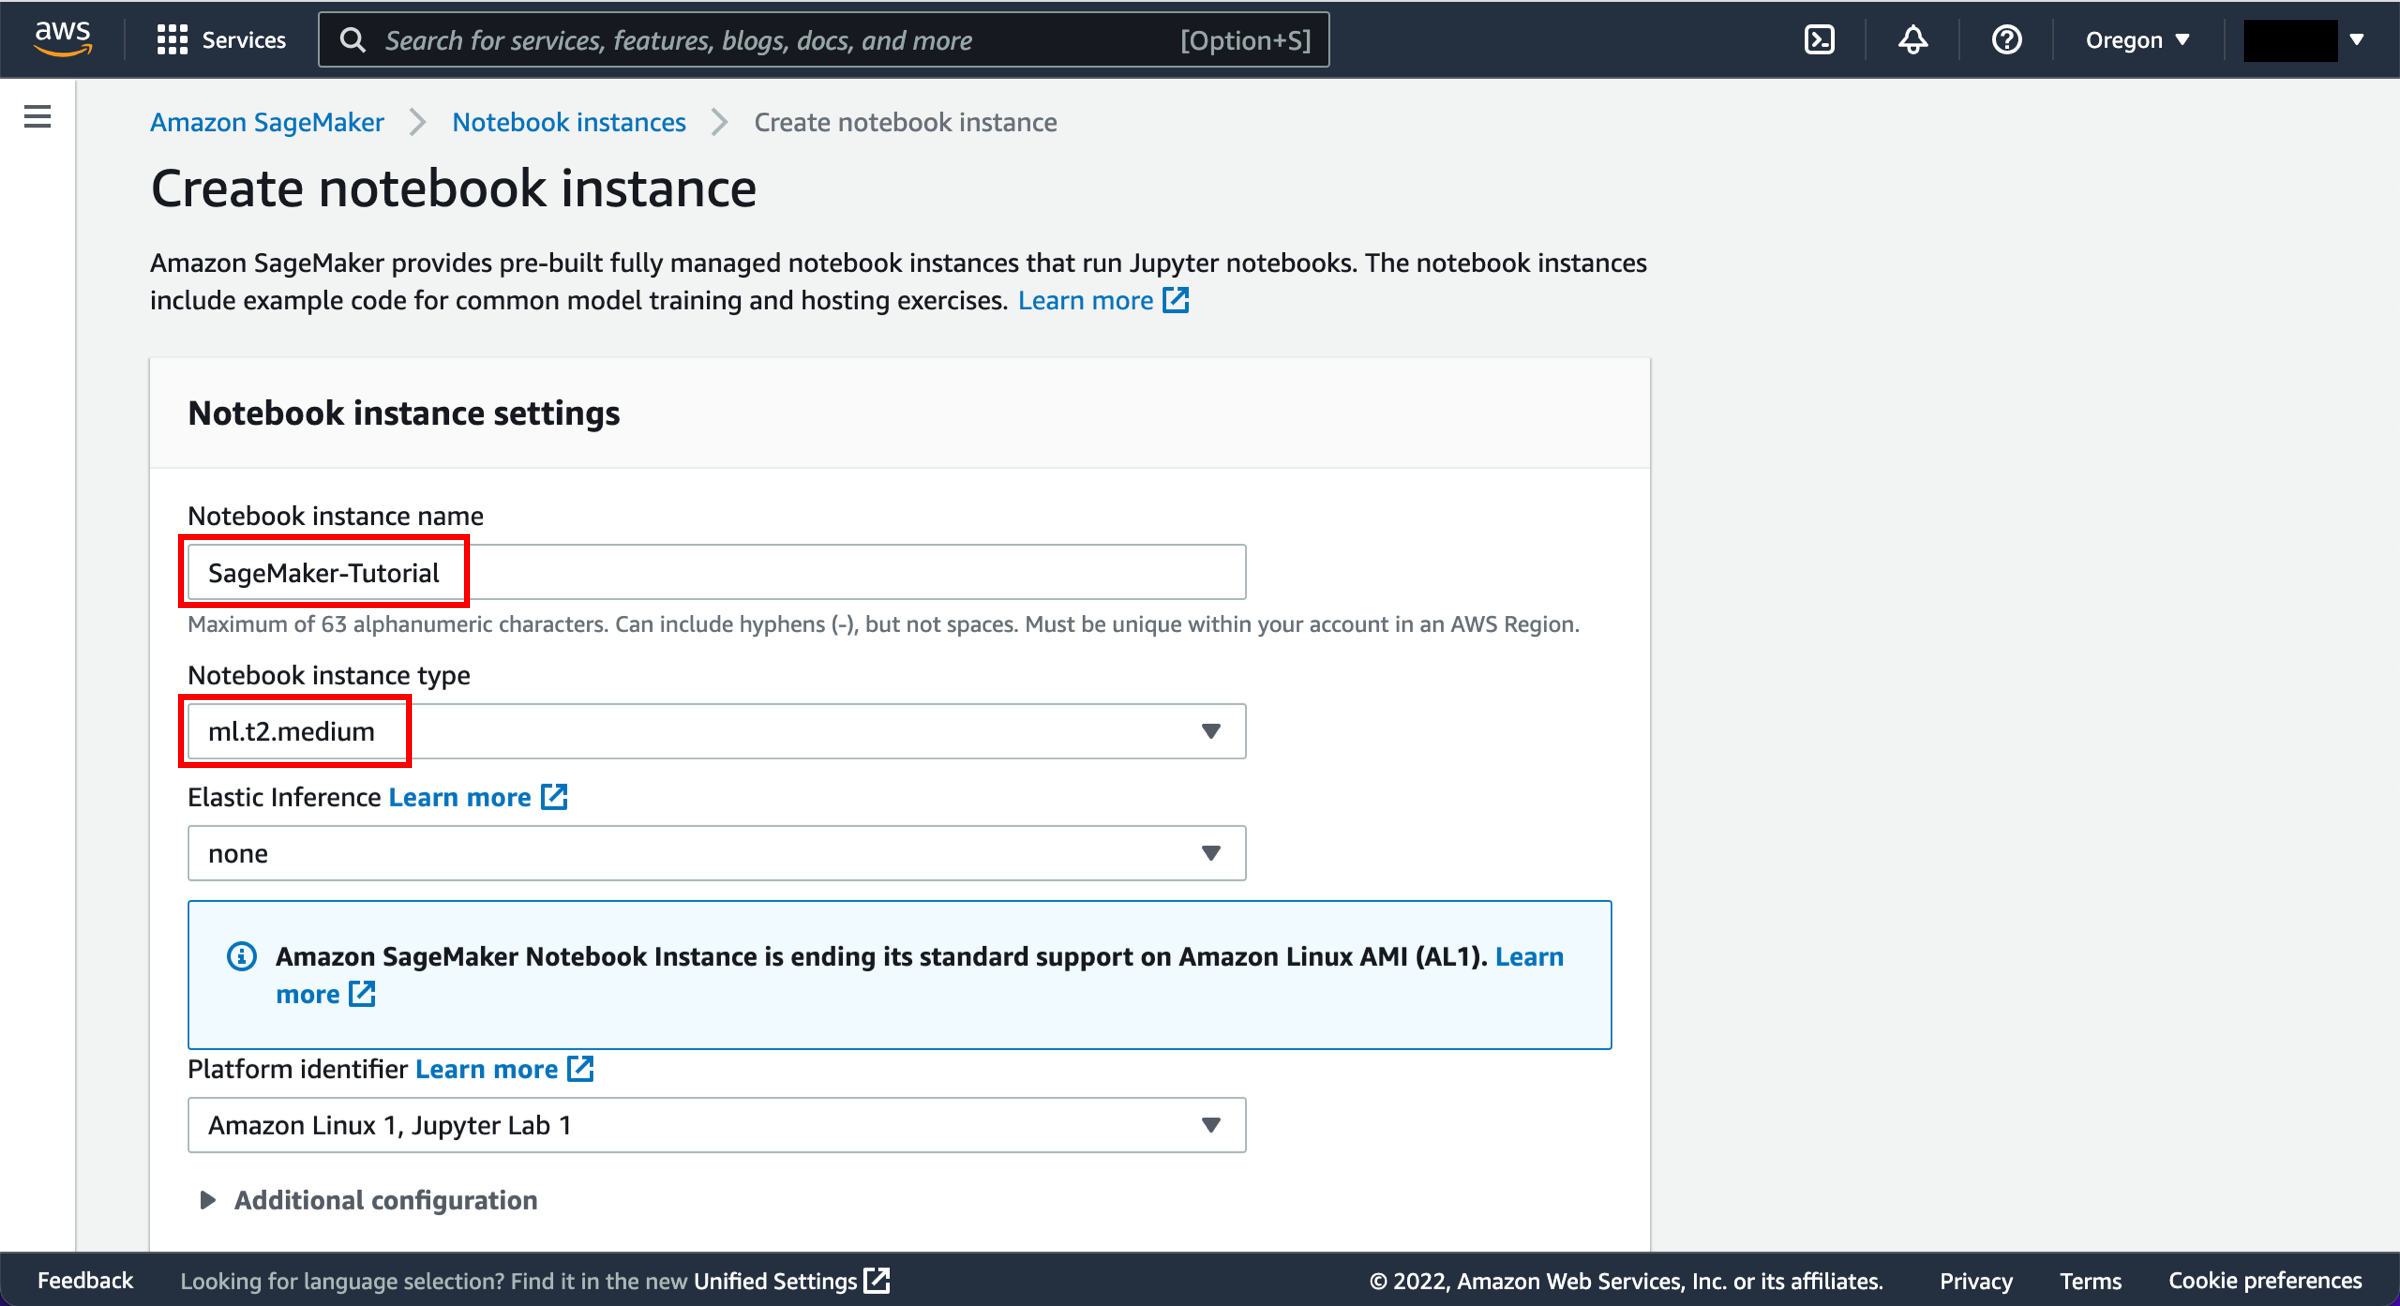

### Step 2: Prepare the Data

#### 1. Import required libraries 
#### 2. Define environment variables necessary to prepare, train, and deploy the ML model

In [1]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # set the region of the instance

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

Matplotlib is building the font cache; this may take a moment.


Success - the MySageMakerInstance is in the us-west-2 region. You will use the 433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


#### 3. Create the S3 bucket to store the data and make sure a unique name is added for the bucket

In [5]:
bucket_name = 'cg-bucket441' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


#### 4. Download data to SageMaker instance. 
#### 5. Load data into a dataframe. 

In [6]:
try:
  urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
  print('Success: downloaded bank_clean.csv.')
except Exception as e:
  print('Data load error: ',e)

try:
  model_data = pd.read_csv('./bank_clean.csv',index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


#### 6. Shuffle and split data into training and test data. 

**Training Data** 70% of customers - used during the model training loop. Gradient-based optimization iteratively refines model parameters by finding model parameter values that minimize model error. This is achieved with the use of the gradient of the model loss function. 

**Test Data** 30% of customers - used to evaluate model performance and measure how well the trained model generalizes to unseen data. 

In [7]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(28831, 61) (12357, 61)


### Step 3: Training the ML Model

#### 7. Use training dataset to train machine learning model. Reformat the header and first column of the training data and load the data from the S3 bucket. Step requires Amazon Sagemaker's pre-built XGBost algorithm.

In [8]:
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

#### 8. Set up Amazon SageMaker session. 
#### 9. Create XGBoost model (estimator) instance 
#### 10. Define model's hyperparameters. 

In [9]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)

#### 11. Start training job using gradient optimization on a ml.m4.xlarge instance. 

Training logs will generate in the Jupyter notebook. 

In [10]:
xgb.fit({'train': s3_input_train})


2022-11-16 17:23:43 Starting - Starting the training job...
2022-11-16 17:24:09 Starting - Preparing the instances for trainingProfilerReport-1668619423: InProgress
.........
2022-11-16 17:25:27 Downloading - Downloading input data...
2022-11-16 17:26:11 Training - Downloading the training image......
2022-11-16 17:27:07 Training - Training image download completed. Training in progress.Arguments: train
[2022-11-16:17:27:05:INFO] Running standalone xgboost training.
[2022-11-16:17:27:05:INFO] Path /opt/ml/input/data/validation does not exist!
[2022-11-16:17:27:05:INFO] File size need to be processed in the node: 3.38mb. Available memory size in the node: 8823.92mb
[2022-11-16:17:27:05:INFO] Determined delimiter of CSV input is ','
[17:27:05] S3DistributionType set as FullyReplicated
[17:27:05] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[17:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes,

### Step 4: Deploy the model 

#### 12. Deploys model on a server
#### 13. Creates a SageMaker endpoint that can be accessed. 

In [11]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')


-------!

#### 14. Predict whether customers in the test data enrolled for the bank product. 

In [12]:
from sagemaker.serializers import CSVSerializer

test_data_array = test_data.drop(['y_no', 'y_yes'], axis=1).values #load the data into an array
xgb_predictor.serializer = CSVSerializer() # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(12357,)


### Step 5: Evaluate Model Performance

#### 15. Evaluate performance and accuracy of the model

Code compares actual and predicted values in a confusion matrix table. 

Based on the prediction, a customer will enroll for a certificate of deposit accurately for 90% of customers in the test data, with a precision of 65% (278/429) for enrolled and 90% (10,785/11,928) for didn't enroll. 

In [14]:
cm = pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 89.5%

Predicted      No Purchase    Purchase
Observed
No Purchase    90% (10769)    37% (167)
Purchase        10% (1133)     63% (288) 



### Step 6: Clean Up

#### 16. Delete endpoint

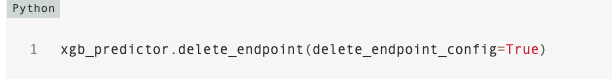



#### 17. Delete training artifacts and S3 bucket

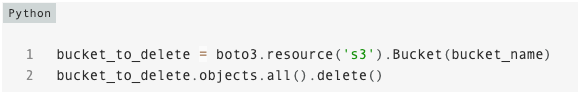

#### 18. Stop and delete your SageMaker Notebook. 